In [19]:
# the goal of this notebook is to use 4 machine learning models:
# logistic regression, Knn, random forest, Svm 
# to predict deepface race-classification errors and compare their performance the baseline classifier

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

train = pd.read_parquet("../data/ml_ready/train_ml_ready.parquet")
val   = pd.read_parquet("../data/ml_ready/val_ml_ready.parquet")

print(train.shape, val.shape)
train.head()
# loading the feature datasets i built previously so i can train ML models on them

(7000, 12) (2100, 12)


,pred_gender,pred_gender_score,pred_race,pred_race_score,error,file,race_true,gender_true,img_path,brightness,contrast,saturation
0,Woman,88.418669,black,43.714210,None,train/60423.jpg,Black,Female,../data/processed/balanced_images/train/60423.jpg,48.987080,59.403837,167.363665
1,Man,97.433734,black,78.286773,None,train/45029.jpg,Black,Female,../data/processed/balanced_images/train/45029.jpg,141.144018,61.018735,126.112693
2,Woman,99.483669,latino hispanic,41.124514,None,train/81730.jpg,Black,Female,../data/processed/balanced_images/train/81730.jpg,32.576097,43.355361,46.195073
3,Man,89.559507,indian,58.377320,None,train/72069.jpg,Black,Female,../data/processed/balanced_images/train/72069.jpg,106.053985,67.849858,49.254235
4,Man,64.608073,black,34.814405,None,train/37655.jpg,Black,Female,../data/processed/balanced_images/train/37655.jpg,55.268659,29.317591,129.966129


In [3]:
train["race_true_clean"] = train["race_true"].str.lower().str.replace("_", " ")
train["pred_race_clean"] = train["pred_race"].str.lower()

val["race_true_clean"] = val["race_true"].str.lower().str.replace("_", " ")
val["pred_race_clean"] = val["pred_race"].str.lower()

y_train = (train["race_true_clean"] != train["pred_race_clean"]).astype(int)
y_val   = (val["race_true_clean"]   != val["pred_race_clean"]).astype(int)

feat_cols = ["pred_race_score", "pred_gender_score", "brightness", "contrast", "saturation"]

X_train = train[feat_cols]
X_val   = val[feat_cols]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
# cleaning the labels and building the target 0 = correct, 1 = error
# then selecting and scaling the numeric features for all future ML models

# Nb: to make sure accuracy and the other metrics actually reflect the model’s ability to detect deepface errors 
# i defined the ML target here as 1 = error and 0 = correct.
# notebook 3 used the opposite convention but only for descriptive analysis

In [5]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score

def evaluate_model(y_true, y_pred):
    """
    I realised the dataset is imbalanced class 1 dominates , accuracy alone becomes misleading
    a model can reach ~66% accuracy just by always predicting the majority class
    
    so I add use Precision, Recall, F1-score and ROC-AUC to see if the model actually learns
    to detect real deepface errors instead of just copying the class distribution.
    """
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

In [6]:
# logistic regression:

Logistic Regression:
Accuracy: 0.6671428571428571
F1-score: 0.7998854852562267
Precision: 0.6681013868962219
Recall: 0.9964336661911555
ROC-AUC: 0.5010821626084717

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.01      0.01       698
           1       0.67      1.00      0.80      1402

    accuracy                           0.67      2100
   macro avg       0.56      0.50      0.41      2100
weighted avg       0.59      0.67      0.54      2100



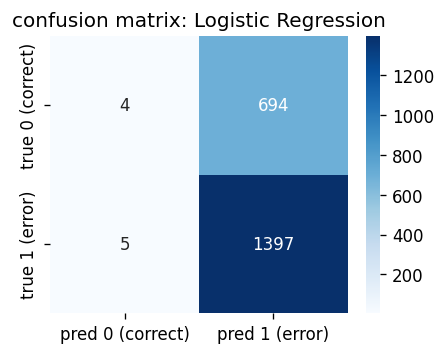

In [22]:
log_model = LogisticRegression(max_iter=300, random_state=42)
log_model.fit(X_train_scaled, y_train)
log_pred = log_model.predict(X_val_scaled)
log_acc = accuracy_score(y_val, log_pred)
print("Logistic Regression:")
evaluate_model(y_val, log_pred)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, log_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["pred 0 (correct)", "pred 1 (error)"],
            yticklabels=["true 0 (correct)", "true 1 (error)"])
plt.title("confusion matrix: Logistic Regression")
plt.show()

In [18]:
# regression performs poorly on this task: 
# even if accuracy is ~0.667, this number is misleading because the model simply
# predicts the majority class error = 1 almost all the time

# recall for class 1 is 1.00 it finds every error
# but recall for class 0 is 0.01 so it totally fails to detect correct predictions

# the model does not learn the real structure of the data it collapses to the majority class
# in conclusion: logistic regression is too simple for modeling deepface error patterns

In [26]:
# interpretation of the regression:
# the model predicts the majority class "error" = 1 almost all the time
# this is why accuracy = 0.667 and recall for class 1 = 1.00

# logistic regression fails to identify the minority class correct = 0
# only 4 samples out of 698 correct predictions are detected 
# this confirms that logistic regression is too simple for this task

In [27]:
# KNN:


KNN(k=3)
Accuracy: 0.5814285714285714
Accuracy: 0.5814285714285714
F1-score: 0.6986630099417209
Precision: 0.6726072607260726
Recall: 0.7268188302425107
ROC-AUC: 0.5081085555224014

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.29      0.31       698
           1       0.67      0.73      0.70      1402

    accuracy                           0.58      2100
   macro avg       0.51      0.51      0.51      2100
weighted avg       0.56      0.58      0.57      2100



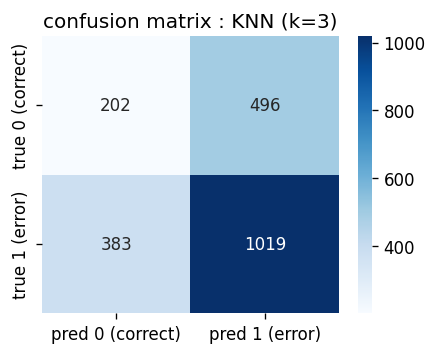


KNN(k=5)
Accuracy: 0.5919047619047619
Accuracy: 0.5919047619047619
F1-score: 0.7128978224455611
Precision: 0.6721415034744157
Recall: 0.7589158345221113
ROC-AUC: 0.5076814129630614

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.26      0.29       698
           1       0.67      0.76      0.71      1402

    accuracy                           0.59      2100
   macro avg       0.51      0.51      0.50      2100
weighted avg       0.56      0.59      0.57      2100



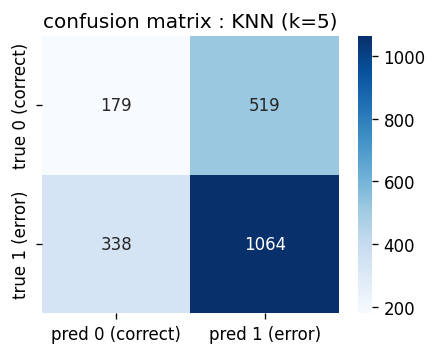


KNN(k=7)
Accuracy: 0.6033333333333334
Accuracy: 0.6033333333333334
F1-score: 0.7267956707117088
Precision: 0.6727383120825744
Recall: 0.7902995720399429
ROC-AUC: 0.5090466341575073

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.23      0.28       698
           1       0.67      0.79      0.73      1402

    accuracy                           0.60      2100
   macro avg       0.51      0.51      0.50      2100
weighted avg       0.57      0.60      0.58      2100



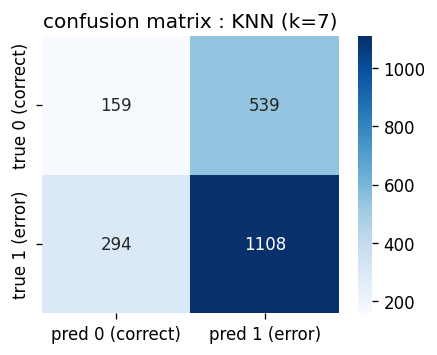


class balance val: [ 698 1402]

class balance val: [ 698 1402]


In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

k_values = [3, 5, 7]
knn_results = {}
knn_preds = {}

for k in k_values:
    print(f"\nKNN(k={k})")
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    pred = knn.predict(X_val_scaled)
    knn_results[k] = accuracy_score(y_val, pred)
    knn_preds[k] = pred

    print("Accuracy:", knn_results[k])
    evaluate_model(y_val, pred)
    
    cm = confusion_matrix(y_val, pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["pred 0 (correct)", "pred 1 (error)"],
                yticklabels=["true 0 (correct)", "true 1 (error)"])
    plt.title(f"confusion matrix : KNN (k={k})")
    plt.show()

print("\nclass balance val:", np.bincount(y_val))
print("\nclass balance val:", np.bincount(y_val))

In [29]:
# across k = 3, 5, and 7, KNN reaches accuracies 58–60% that remain below the majority-class baseline 66.76% 
# this shows that KNN does not learn meaningful predictive structure with the current features
# the confusion matrices show that KNN struggles especially on the minority
# this provides further evidence that more flexible models are required to capture DeepFace error patterns

In [30]:
# random forest: 


Random Forest
Accuracy: 0.6761904761904762
F1-score: 0.7885572139303483
Precision: 0.6990077177508269
Recall: 0.9044222539229672
ROC-AUC: 0.5610936484514549

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.22      0.31       698
           1       0.70      0.90      0.79      1402

    accuracy                           0.68      2100
   macro avg       0.62      0.56      0.55      2100
weighted avg       0.64      0.68      0.63      2100



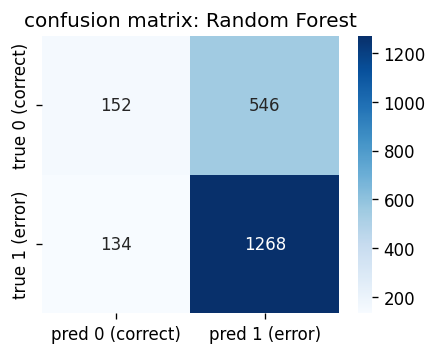

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
print("\nRandom Forest")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight=None
)

rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_val_scaled)

evaluate_model(y_val, rf_pred)

cm = confusion_matrix(y_val, rf_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["pred 0 (correct)", "pred 1 (error)"],
            yticklabels=["true 0 (correct)", "true 1 (error)"])
plt.title("confusion matrix: Random Forest")
plt.show()

In [32]:
# random forest : 
# accuracy = 0.676 is only slightly above the majority-class baseline 0.667
# the dataset is imbalanced 67% errors, so accuracy alone is misleading

# F1-scores show the real behavior:
# class 1 error: F1 = 0.79 -> the model is very good at predicting errors
# class 0 correct: F1 = 0.31 -> it struggles to detect correct predictions

# so random forest learns some non-linear patterns not like logistic regression or Knn 
# but it still mainly predicts the majority class error and misses most correct cases

# confusion matrix:
# it correctly catches 1268/1402 errors but only 152/698 correct predictions features are still too weak to model failures

In [33]:
# support vector machine -> SVM:

SVM (linear) accuracy: 0.6676190476190477
Accuracy: 0.6676190476190477
F1-score: 0.8006853226727584
Precision: 0.6676190476190477
Recall: 1.0
ROC-AUC: 0.5

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       698
           1       0.67      1.00      0.80      1402

    accuracy                           0.67      2100
   macro avg       0.33      0.50      0.40      2100
weighted avg       0.45      0.67      0.53      2100



/Users/leobideau/Desktop/fairface-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/leobideau/Desktop/fairface-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/leobideau/Desktop/fairface-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

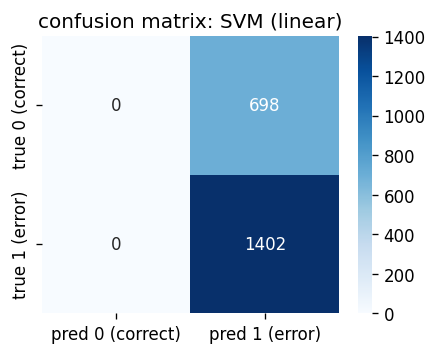

SVM (RBF) accuracy: 0.6638095238095238
Accuracy: 0.6638095238095238
F1-score: 0.7951247823563552
Precision: 0.6702544031311155
Recall: 0.9771754636233951
ROC-AUC: 0.5057797088890614

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.03      0.06       698
           1       0.67      0.98      0.80      1402

    accuracy                           0.66      2100
   macro avg       0.55      0.51      0.43      2100
weighted avg       0.59      0.66      0.55      2100



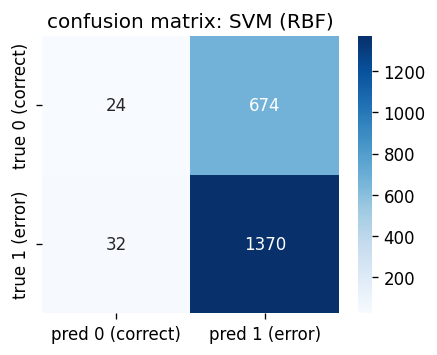

class balance val: [ 698 1402]


In [34]:
svm_linear = SVC(kernel="linear")
svm_linear.fit(X_train_scaled, y_train)
svm_linear_pred = svm_linear.predict(X_val_scaled)

print("SVM (linear) accuracy:", accuracy_score(y_val, svm_linear_pred))
evaluate_model(y_val, svm_linear_pred)

cm_linear = confusion_matrix(y_val, svm_linear_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm_linear, annot=True, fmt="d", cmap="Blues",
            xticklabels=["pred 0 (correct)", "pred 1 (error)"],
            yticklabels=["true 0 (correct)", "true 1 (error)"])
plt.title("confusion matrix: SVM (linear)")
plt.show()

svm_rbf = SVC(kernel="rbf")
svm_rbf.fit(X_train_scaled, y_train)
svm_rbf_pred = svm_rbf.predict(X_val_scaled)

print("SVM (RBF) accuracy:", accuracy_score(y_val, svm_rbf_pred))
evaluate_model(y_val, svm_rbf_pred)


cm_rbf = confusion_matrix(y_val, svm_rbf_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm_rbf, annot=True, fmt="d", cmap="Blues",
            xticklabels=["pred 0 (correct)", "pred 1 (error)"],
            yticklabels=["true 0 (correct)", "true 1 (error)"])
plt.title("confusion matrix: SVM (RBF)")
plt.show()


print("class balance val:", np.bincount(y_val))

In [35]:
# both SVM models reach accuracies close to the majority baseline 66.76%
# which confirms that accuracy alone is misleading on this imbalanced dataset

# linear SVM collapses completely : it predicts class 1 error for every sample
# just like logistic regression meaning it learns no useful decision

# RBF SVM captures more non-linear structure but the improvement is minimal:
# it still heavily favors the majority class and struggles to detect correct predictions
# this confirms that the current feature set does not contain strong predictive signals

In [36]:
import numpy as np
naive_predictions = np.ones_like(y_val)
# baseline: always predict "error" majority class = 1

In [37]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def collect_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_pred)
    }
results = {
    "Logistic Regression": collect_metrics(y_val, log_pred),
    "KNN (k=3)":            collect_metrics(y_val, knn_preds[3]),
    "KNN (k=5)":            collect_metrics(y_val, knn_preds[5]),
    "KNN (k=7)":            collect_metrics(y_val, knn_preds[7]),
    "Random Forest":        collect_metrics(y_val, rf_pred),
    "SVM (linear)":         collect_metrics(y_val, svm_linear_pred),
    "SVM (RBF)":            collect_metrics(y_val, svm_rbf_pred),
    "Baseline (always error)": collect_metrics(y_val, naive_predictions)
}

df_results = pd.DataFrame(results).T
df_results = df_results.round(4)

df_results

,Accuracy,F1-score,Precision,Recall,ROC-AUC
Logistic Regression,0.6671,0.7999,0.6681,0.9964,0.5011
KNN (k=3),0.5814,0.6987,0.6726,0.7268,0.5081
KNN (k=5),0.5919,0.7129,0.6721,0.7589,0.5077
KNN (k=7),0.6033,0.7268,0.6727,0.7903,0.5090
Random Forest,0.6762,0.7886,0.6990,0.9044,0.5611
SVM (linear),0.6676,0.8007,0.6676,1.0000,0.5000
SVM (RBF),0.6638,0.7951,0.6703,0.9772,0.5058
Baseline (always error),0.6676,0.8007,0.6676,1.0000,0.5000


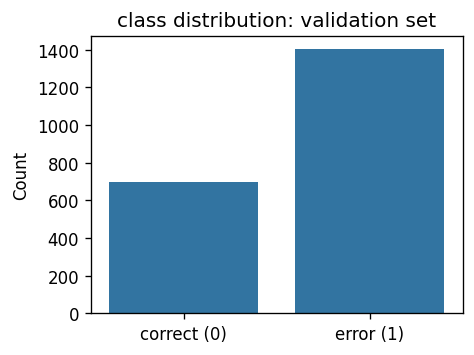

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(4,3))
sns.barplot(x=["correct (0)", "error (1)"], y=np.bincount(y_val))
plt.title("class distribution: validation set")
plt.ylabel("Count")
plt.show()

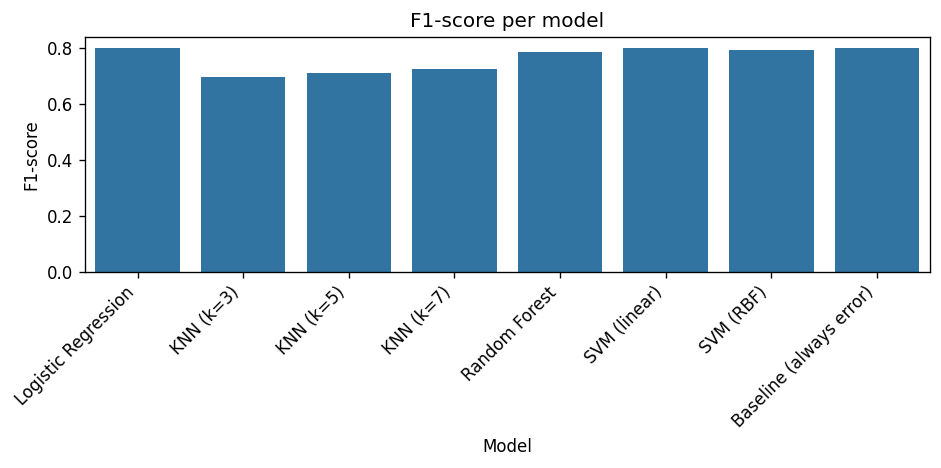

In [39]:
df_plot = df_results.reset_index().rename(columns={"index": "Model"})

plt.figure(figsize=(8,4))
sns.barplot(data=df_plot, x="Model", y="F1-score")
plt.xticks(rotation=45, ha="right")
plt.title("F1-score per model")
plt.tight_layout()
plt.show()

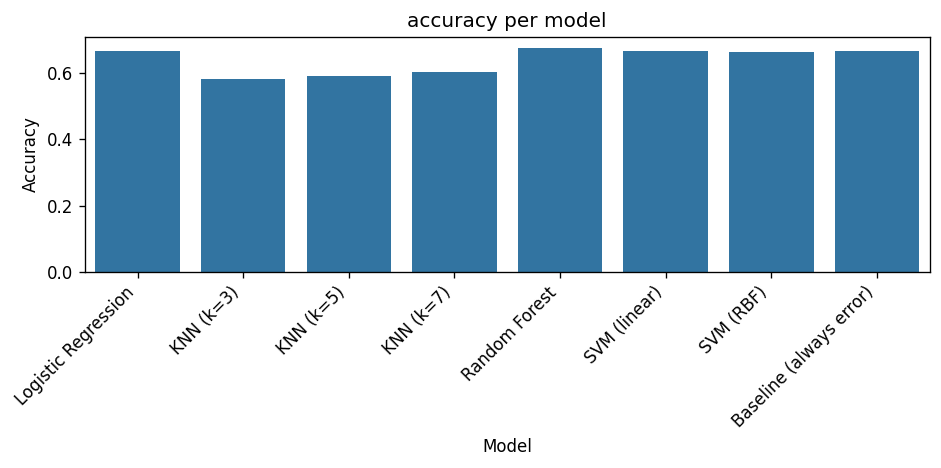

In [40]:
plt.figure(figsize=(8,4))
sns.barplot(data=df_plot, x="Model", y="Accuracy")
plt.xticks(rotation=45, ha="right")
plt.title("accuracy per model")
plt.tight_layout()
plt.show()

In [41]:
# final conclusion: 
# unfortunately across all four models performance stays close to the majority-class baseline
# KNN performs the worst, while Random Forest is the only model that slightly do better
# all models struggle to detect the minority class correct predictions 
# and ROC-AUC scores around 0.50 basically means random guessing: these features don't help predict errors at all

# this shows that the available features do not contain strong predictive signals about when deepface will fail...
# I'll try to achieve higher performance with richer feature representations by updating previous notebooks 
# Nb: I'll do notebooks BIS so we can compare the before and after